---
title: "Clustering"
format:
  html:
      embed-resources: true
      code-fold: true
---

## Introduction 

For this section, we will be applying clustering analyis to both record and text datasets. Starting with the record dataset, our feature data $X$ will be comprised of US Census data gathered by Integrated Public Use Microdata Series (IPUMS). [^1] This dataset includes many reported variables regarding people, their location, and their household. An important aspect to note about this process is that while this dataset does contain valuable information on each person's mode of transportation to work, which is ultimately the target variable of this analysis, clustering is an unsupervised learning method that is generally done without knowing a target variable or any relationships within the data. Therefore, this data will contain the following features, each of which can be important indicators of one's lifestyle and how they might be impacted by public transit trends and phenomena:

- City population (00s): The population of the city in which they reside (missing values or unincorporated cities will be dropped, as the person is less likely to have access to public transit)
- Age (years)
- Total personal income (dollars)

Secondly, clustering is a valuable tool for understanding text data and how language can be analyzed via numerical methods. The feature data for this process will be Yelp reviews for some of the most commonly used public transit systems in the US. Specifically, the top seven public transit systems from the Federal Transit Administration's 2022 Ridership Report. These are:

- Metropolitan Transit Authority (New York City) [^2]
- Los Angeles County Metropolitan Transportation Authority [^3]
- Chicago Transit Authority [^4]
- Southeastern Pennsylvania Transportation Authority (Philadelphia) [^5]
- Massachusetts Bay Transportation Authority (Boston) [^6]
- Washington Metropolitan Area Transit Authority (Washington, D.C.) [^7]
- San Francisco Bay Area Rapid Transit District [^8]

This data will be clustered based on the review text, then compared against the associated numerical ratings in order to gather insights on how the language that people use can be predictive of their overall sentiment or opinion on public transit.

## Theory

The goal of clustering is to find groups that convey similarity withing the data. This is generally done by assessing some distance metric between data points to determine the likelihood that they would belong in the same cluster. However, this can be done in several different ways. In this analysis, we will be applying K-Means, DBSCAN, and hierarchical clustering to our record data, and just K-Means to our text data. Thus, it is important to understand the similarities and differences between these methods, as well as model selection methods for making sense of the clustering.

### K-Means

K-Means clustering is, in simplest terms, "centroid based cluster identification". To perform this, a user will define number of $k$ clusters to partition $n$ observations into. Each cluster will have a centroid, which is essentially the mean of all of its data points. All observations will be placed in the cluster with the nearest mean to itself, which can be measured using several distance metrics, usually Euclidean distance. In practice, this results in partitions called Voronoi cells, which are tesselated regions around each observation that represent the space occupied by that observation (i.e. the space in which that observation is the closest data point).

This method minimizes variances (squared Euclidean distances) within clusters. The algorithm works by first randomly selecting a set of $k$ centroids, which are used to initially place the observations in a cluster. There is then an iterative approach to optimize the location of each centroid until either the centroids stabilize in set locations, or if the iterations hit a user-defined cap. Ultimately, K-means tends to be useful because of its simplicity. While it often struggles with data that has clusters of unusual shpaes due to the circular nature of converging around a centroid, it is often very efficient in grouping data that follows its requirements. [^9]

### DBSCAN

Density-based spacial clustering of applications with noise (DBSCAN) is a non-parametric algorithm which groups points that are close to one another. This differs from K-means in that instead of searching for nearby centroids, for each observation we are looking for the nearest other observations. In practice, this means that each cluster is a high-density region of data points, while they are each separated by low-density regions of datapoints.

The usefulness of this method comes when irregularly-shaped clusters are present in the data. While searching for centroids generally results in spherical clusters, DBSCAN can identify clusters of all shapes and sizes, so long as those shapes represent continuous regions of high density. Additionally, when presented with noise, DBSCAN effectively filters out data points that do not coincide with others. An observation that is far away from any other will not be placed in a high-density cluster; instead, it will be identified as a point that does not have close neighbors, and may be left in its own cluster.

The algorithm follows the following steps: [^10]

- An observation is arbitrarily picked as the starting points
- If the number of observations within a specified distance exceeds a specified minimum number, those points will be considered a cluster
- Recursively, this process is done for each point in the cluster to expand the cluster

### Hierarchical Clustering

While the two methods outlined above are examples of partitional clutering (i.e. they group data into divisions that do not overlap), hierarchical clustering produces nested clusters, in which there can essentially be "clusters of clusters". In this case, there is no assumed value of $k$, as the algorithm creates clusters based on the organization of the data. This technique can be broken down into two types: Agglomerative and Divisive.

In Agglomerative clustering, each observation represents its own cluster. As observations (and subsequently clusters) are deemed to be similar, pairs of clusters get merged together. This can be thought of as a "bottom up" process, as one moves up the hierarchy for this technique.

Division is the "top down" alternative to this process. In this case, all observations start as one big cluster. Recursively, this cluster is split as observations are deemed dissimilar, until each observation is accounted for in its own cluster. These clusters are often visualized in a dendrogram.

### Silhouette Method

For this process, we will be using the Silhouette Method to evaluate the quality of clustering for each defined number of clusters. This process iterates over each data point and measures the extent to which that observation is more similar to its own cluster than other clusters. A score closer to 1 suggests well-separated clusters, meaning the observations are significantly more similar to their own cluster than to other clusters. Conversely, a score close to -1 suggests that points are closer to other clusters than their own, which denotes poor clustering. A score around 0 indicates that clusters overlap. The purpose of calculating this for each specified $k$ is to allow us to choose the optimal number of clusters. The $k$ that returns the highest silhouette score will allow us to have better-defined clusters.

## Methods

### Record Data

To properly execute clustering techniques, we must first remove categorical variables from the data.

*Note: Much of the code for this section is repurposed from DSAN-5000 Lab 4.1.*

In [50]:
import pandas as pd
ipums = pd.read_csv('../data/cleaned_data/commute_cleaned.csv')
ipums = ipums.drop(columns=['Unnamed: 0','sex','marital_status','race','hispanic','employment'])
ipums = ipums.dropna()
ipums.head()

,city_population_00s,age,income,transportation_type,transportation_time
20273,2881.0,21,10500.0,Private Vehicle,15
20274,2881.0,21,33000.0,Private Vehicle,15
20286,2881.0,57,103000.0,Walk,10
20288,2881.0,19,40000.0,Walk,15
20290,2881.0,23,42000.0,Walk,15


In order to cluster our record data, we will need to determine the optimal $k$ value for the most effective results. Thus, the code below defines functions that do the following:

- Plot the data in the defined clusters, once a parameter is chosen:

In [51]:
import sklearn.cluster
import numpy as np
import matplotlib as plt
from matplotlib.pyplot import subplots
def plot(X,color_vector):
    fig, ax = subplots()
    ax.scatter(X[:,0], X[:,1],c=color_vector, cmap="viridis")
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    ax.grid()
    # fig.savefig("test.png")
    plt.pyplot.show()


- Plot the silhouette scores for each $k$ and return the optimal value for $k$:

In [52]:
from sklearn.metrics import silhouette_score
X = ipums.drop(columns=['transportation_type'])

def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    i_print=False
    X=np.ascontiguousarray(X) 

    params=[]; sil_scores=[]
    sil_max=-1000
    for param in range(2,nmax+1):
        if(algo=="birch"):
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        sil_scores.append(silhouette_score(X,labels))
        params.append(param)


        if(i_print): print(param,sil_scores[-1])
        
        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.pyplot.subplots()
        ax.plot(params, sil_scores, "-o")  
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.pyplot.show()

    return opt_labels

In order to run these functions, we will need to shorten the dataset significantly to a reasonable volume. Thus, the first step before clustering the data will be to create a variable `X_short`, which will randomly sample 1000 rows from the feature data $X$. Next, we will run K-Means, Agglomerative, and Birch clustering algorithms to obtain the optimal value of $k$ for each, as well as the optimal labels for each observational unit. This process is called hyper-parameter tuning.

**K-Means**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


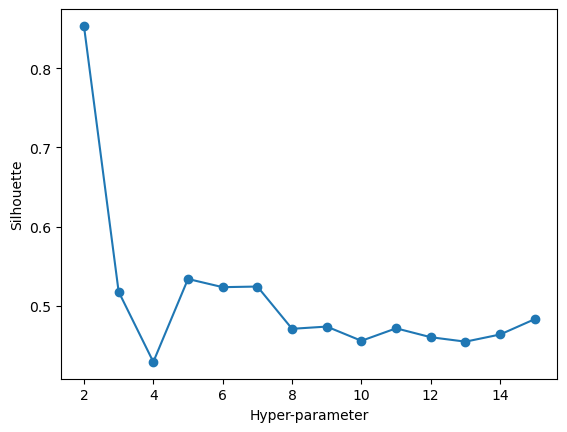

In [53]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)
warnings.simplefilter('ignore', np.ComplexWarning)
warnings.filterwarnings('ignore', "Intel MKL ERROR")
X_short = X.sample(n=1000)
# KMEANS
opt_labels=maximize_silhouette(X_short,algo="kmeans",nmax=15, i_plot=True)

**Agglomerative Clustering**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


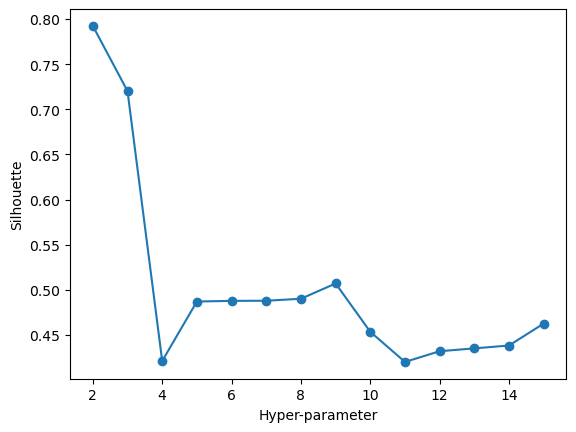

In [54]:
# AGGLOMERATIVE CLUSTERING
opt_labels=maximize_silhouette(X_short,algo="ag",nmax=15, i_plot=True)

**Birch**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


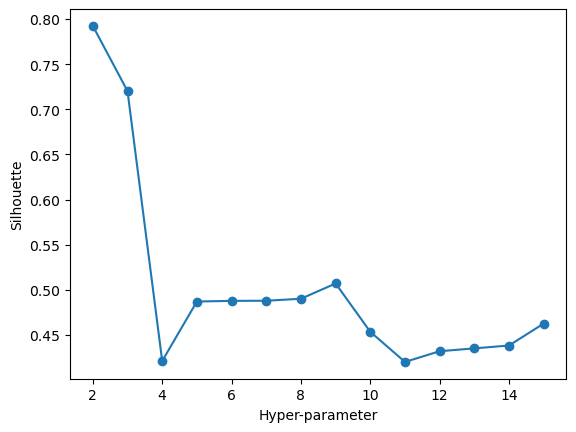

In [55]:
# BIRCH
opt_labels=maximize_silhouette(X_short,algo="birch",nmax=15, i_plot=True)

For each of these plots, the optimal parameter given is 2. Therefore, in the "Results" section below, that will be the defined $k$ number of clusters for each process.

### Text Data

In [26]:
yelp = pd.read_csv('../data/cleaned_data/total_yelp.csv')
yelp = yelp.drop(columns=['Unnamed: 0'])
yelp.head()

,Rating,Date,Review
0,5,"Jul 26, 2023",I had to compliment WMATA on the shuttle servi...
1,1,"Oct 27, 2023",Since when did metro close the doors to their ...
2,1,"Sep 29, 2023",So many things wrong with wmata I can't even b...
3,5,"Sep 23, 2023","I WFH, and WMATA has been very helpful in my m..."
4,4,"Sep 18, 2022",I took the metro while visiting DC. I began at...


In order to cluster text data, the reviews gathered from Yelp must be cleaned and tokenized using `nltk` in Python. The steps for this are as follows, with the code directly below:

- Download stopwords from `nltk`
- Define a list of stoplemmas
- Iterate over each review in the dataset
- Tokenize the words
- Remove stopwords
- Remove numbers
- Replace hyphens in hyphenated words with spaces
- Remove empty tokens and special characters
- Lemmatize
- Remove stoplemmas
- Re-join the individual tokens in the sentence into a single string
- Create new array with updated strings

*Note: Much of this code is repurposed from: https://jjacobs.me/dsan5000/463a01339cf0f456ba54a1849df50d1a22c247e3/writeups/clustering/DSAN5000_Clustering_Lab.html#finding-the-most-prominent-signal-via-clustering*

In [27]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from tqdm import tqdm
tqdm.pandas()
import string
from collections import Counter
token_counter = Counter()
from nltk.corpus import stopwords
custom_stoplemmas = [
    'be',
    'ir',
    'll',
    'nt',
    'quot',
    'rd',
    's',
    've'
]

def remove_special_chars(token):
  return token.translate(str.maketrans('', '', string.punctuation))

def remove_digits(token):
  return ''.join([c for c in token if not c.isdigit()])

def clean_review(review_text):
  review_cleaned = review_text.lower()
  review_sents = sent_tokenize(review_cleaned)
  clean_sents = []
  for cur_sent in review_sents:
    sent_tokens = word_tokenize(cur_sent)
    sent_tokens_cleaned = [t for t in sent_tokens if t not in stopwords.words('english')]
    sent_tokens_cleaned = [remove_digits(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t.replace("-", " ") for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [remove_special_chars(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if len(t) > 0]
    sent_tokens_cleaned = [lemmatizer.lemmatize(t) for t in sent_tokens_cleaned]
    sent_tokens_cleaned = [t for t in sent_tokens_cleaned if t not in custom_stoplemmas]
    token_counter.update(sent_tokens_cleaned)
    clean_sent = ' '.join(sent_tokens_cleaned)
    clean_sents.append(clean_sent)
  review_final = ". ".join(clean_sents)
  return review_final
yelp['Review_clean'] = yelp['Review'].progress_apply(clean_review)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/joshsweren/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/joshsweren/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 2434/2434 [00:31<00:00, 77.48it/s] 


Now that the text has been readied for analysis, we can use the `CountVectorizer` function from `sklearn` to vectorize the data.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = yelp['Review_clean'].values
max_document_freq = 0.4
min_document_count = 6
cv = CountVectorizer(max_df=max_document_freq, min_df=min_document_count)
X_text = cv.fit_transform(corpus)
X_text.shape

(2434, 3044)

The following process uses an `NMF` model from `sklearn` to fit the vectorized text data into a defined number of topics. Through exploratory data analysis, it was determined that three topics (clusters) gave the most convincing results. Below we can see the most commonly appearing words in each topic. This is not a particularly useful visualization, as these words are quite general and tend to overlap, but it allows us to see the division of data that will be further visualized as clusters.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


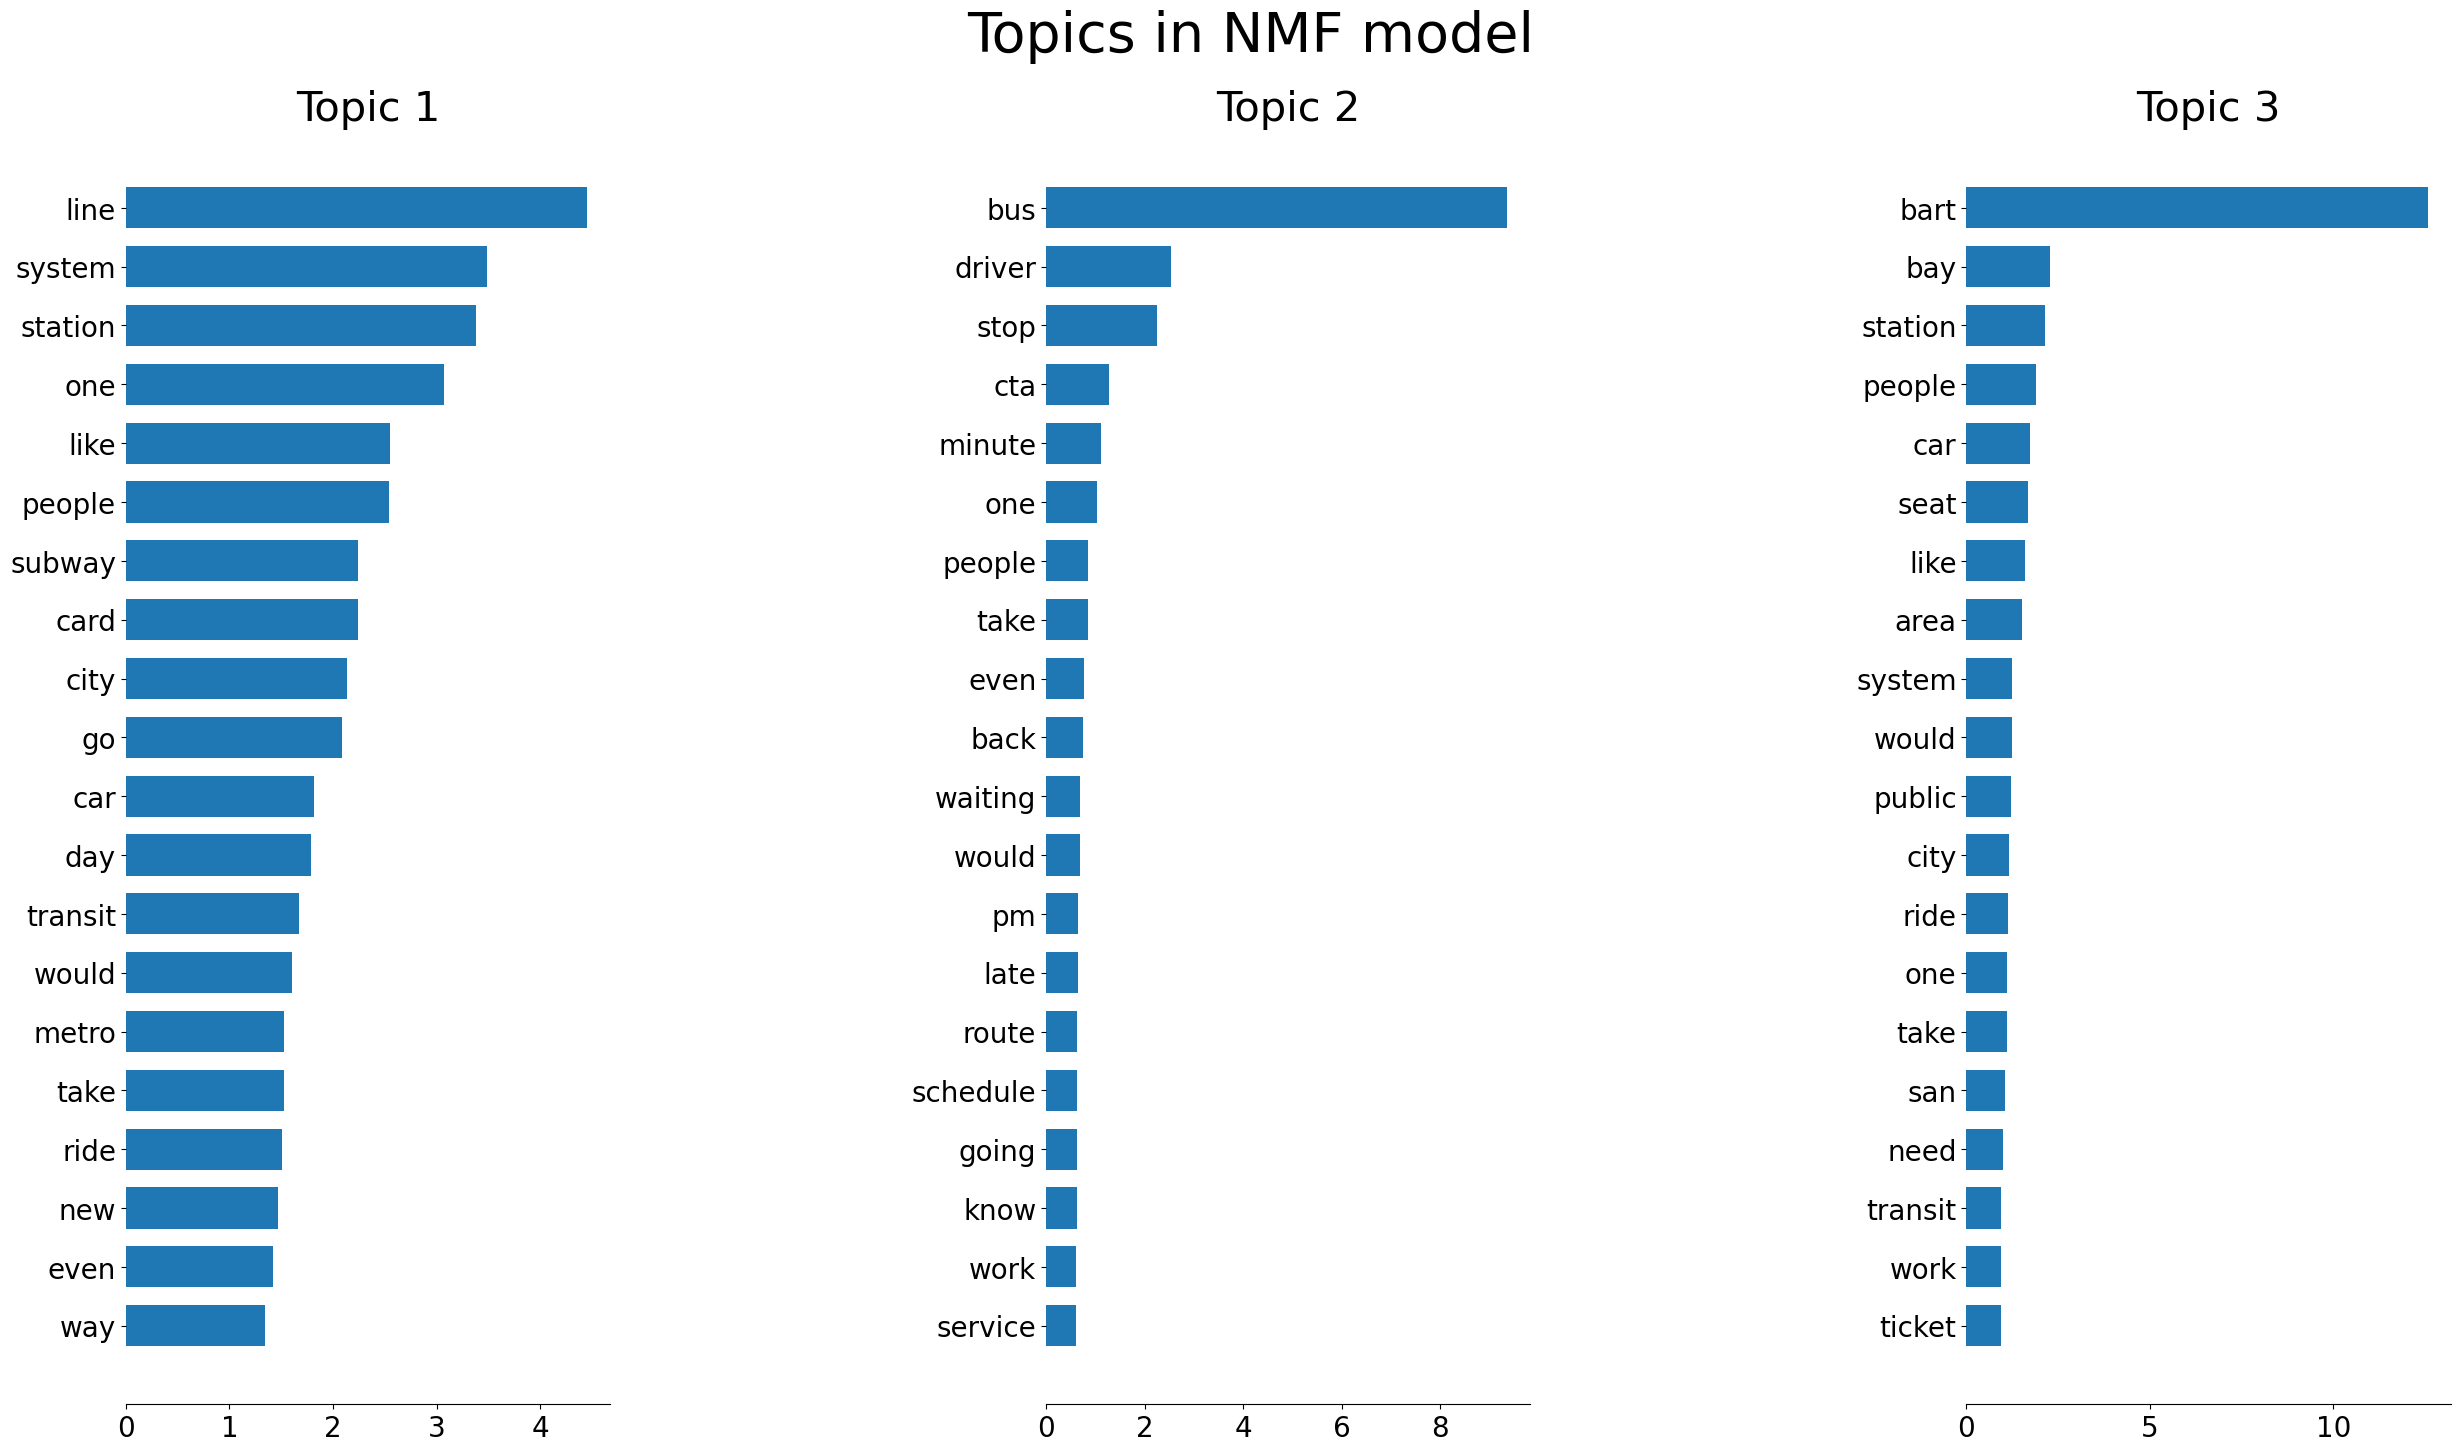

In [31]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.pyplot.subplots(1, 3, figsize=(30, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.pyplot.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.pyplot.show()
n_top_words = 20
num_topics = 3
nmf = NMF(
    n_components=num_topics,
    random_state=5000,
    beta_loss="frobenius",
)
nmf.fit(X_text)
feature_names = cv.get_feature_names_out()
plot_top_words(nmf, feature_names, n_top_words, "Topics in NMF model")

Finally, we will use `TSNE` from `sklearn` to assign clusters to each review:

In [32]:
from sklearn.manifold import TSNE
nmf_ng_components = nmf.components_
W = nmf.transform(X_text)
W_df = pd.DataFrame(W)
W_df['cluster'] = W_df.idxmax(axis=1)
tsne_model = TSNE(
    init='random',
    random_state=5000
)
tsne_embedding = tsne_model.fit_transform(W)
tsne_df = pd.DataFrame(tsne_embedding, columns=['x','y'])
tsne_df['cluster'] = W_df['cluster']
tsne_df['review'] = yelp['Review']
tsne_df.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,x,y,cluster,review
0,4.215911,-47.979015,0,I had to compliment WMATA on the shuttle servi...
1,-0.916922,-17.092419,0,Since when did metro close the doors to their ...
2,5.989328,-12.396338,0,So many things wrong with wmata I can't even b...
3,-0.281190,-59.255077,0,"I WFH, and WMATA has been very helpful in my m..."
4,-0.605770,-15.053738,0,I took the metro while visiting DC. I began at...


In [33]:
from sklearn.cluster import KMeans
kmeans = KMeans(init="random", n_clusters=3, n_init=4, random_state=5000)
kmeans.fit(X_text)
y_pred = kmeans.predict(X_text)
print("Data points in each cluster:")
print(len(y_pred[y_pred==0]))
print(len(y_pred[y_pred==1]))
print(len(y_pred[y_pred==2]))

Data points in each cluster:
288
235
1911


## Results

### Record Data

**K-Means**

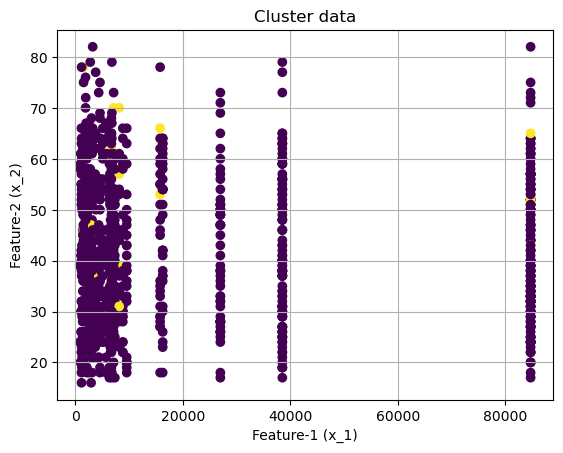

In [56]:
#KMEANS
model = sklearn.cluster.KMeans(n_clusters=2).fit(X_short.to_numpy())
labels=model.predict(X_short.to_numpy())
plot(X_short.to_numpy(),labels)

**Birch**

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


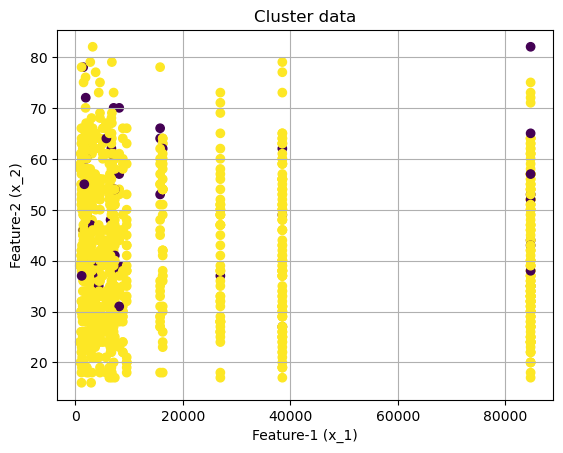

In [57]:
# Birch
model = sklearn.cluster.Birch(n_clusters=2).fit(X_short.to_numpy())
labels=model.predict(X_short.to_numpy())
plot(X_short.to_numpy(),labels)

**Agglomerative Clustering**

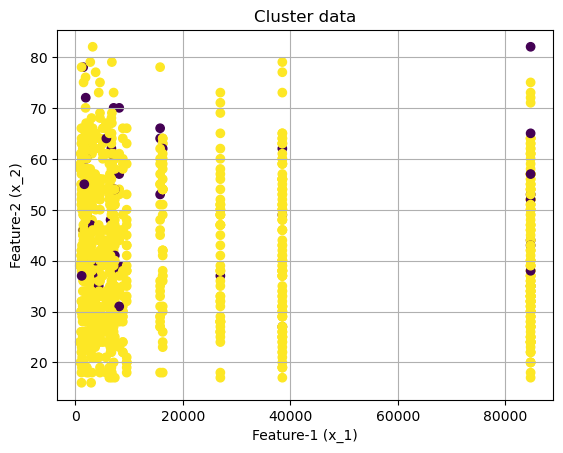

In [59]:
# Agglomerative
model = sklearn.cluster.AgglomerativeClustering(n_clusters=2).fit(X_short.to_numpy())
labels=model.labels_
plot(X_short.to_numpy(),labels)

These results show that the record data was not particularly useful for clustering. As we can see via the plots above, the defined clusters do not line up very well with the data, so new insights are difficult to gather from this.

### Text Data

In [37]:
centroids = kmeans.cluster_centers_
from sklearn.metrics import pairwise_distances_argmin_min
argmins, mins = pairwise_distances_argmin_min(centroids, X_text)
argmin_0 = argmins[0]
argmin_1 = argmins[1]
yelp['y_pred'] = y_pred
pd.crosstab(yelp['Rating'], yelp['y_pred'])

y_pred,0,1,2
Rating,,,
1,68,78,825
2,59,41,242
3,73,45,322
4,63,54,332
5,25,17,190


In [38]:
pd.crosstab(yelp['Rating'], yelp['y_pred'], normalize='all', margins=True)

y_pred,0,1,2,All
Rating,,,,
1,0.027938,0.032046,0.338948,0.398932
2,0.024240,0.016845,0.099425,0.140509
3,0.029992,0.018488,0.132293,0.180772
4,0.025883,0.022186,0.136401,0.184470
5,0.010271,0.006984,0.078061,0.095316
All,0.118324,0.096549,0.785127,1.000000


/var/folders/z5/l6g0391s0qg3vsbnvl7y81n80000gn/T/ipykernel_9854/1050391010.py:4: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(tsne_sample_df, x='x', y='y', hue='cluster', palette=sns.color_palette("tab10"))


<Axes: xlabel='x', ylabel='y'>

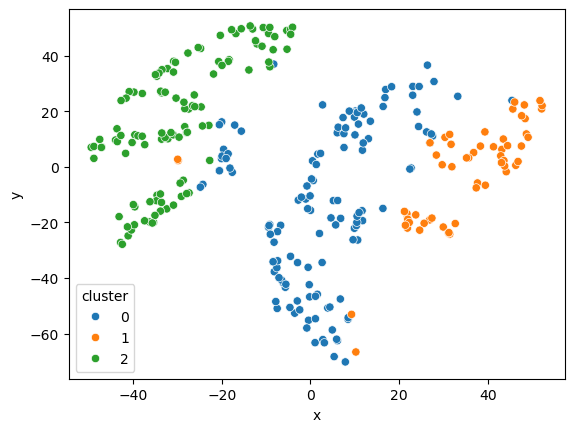

In [39]:
import seaborn as sns
tsne_sample_size = 300
tsne_sample_df = tsne_df.sample(tsne_sample_size, random_state=5000)
sns.scatterplot(tsne_sample_df, x='x', y='y', hue='cluster', palette=sns.color_palette("tab10"))

In [40]:
import textwrap
mywrap = lambda x: textwrap.wrap(x, width=60)
tsne_sample_df['review'] = tsne_sample_df['review'].apply(lambda x: x if type(x) == str else '')
tsne_sample_df['review_wrap'] = tsne_sample_df['review'].apply(lambda x: '<br>'.join(mywrap(x)))
import plotly.express as px
review_fig = px.scatter(tsne_sample_df, x='x', y='y', color='cluster',
                        hover_data=['review_wrap'], template='simple_white')
review_fig.update(layout_coloraxis_showscale=False)
review_fig.update_traces(marker=dict(size=12),selector=dict(mode='markers'))
review_fig.show()

These visualizations show that clustering was illustrative for the text data. The clusters appear to be well-aligned with the data, and this allows us to gather significant insights on the reviews.

## Conclusions

In summation, it is clear that text data from Yelp reviews can effectively be partitioned into clusters using the K-means method. This is significant because it allows us to categorize reviews into groups to better understand how people are discussing the most used public transit systems in the US. By doing this, we can make inferences on how and why public transit affects its respecitive cities and the corresponding population, which can be useful in explaining usage trends.

[^1]: Steven Ruggles, Sarah Flood, Matthew Sobek, Danika Brockman, Grace Cooper,  Stephanie Richards, and Megan Schouweiler. IPUMS USA: Version 13.0 [dataset]. Minneapolis, MN: IPUMS, 2023.
https://doi.org/10.18128/D010.V13.0

[^2]: “Metropolitan Transportation Authority - New York, NY,” Yelp, https://www.yelp.com/biz/metropolitan-transportation-authority-new-york-6 (accessed Nov. 14, 2023).

[^3]: “Metro Los Angeles - Los Angeles, CA,” Yelp, https://www.yelp.com/biz/wmata-washington (accessed Nov. 14, 2023).

[^4]: “Chicago Transit Authority - Chicago, IL,” Yelp, https://www.yelp.com/biz/metro-los-angeles-los-angeles (accessed Nov. 14, 2023).

[^5]: “Septa - Philadelphia, PA,” Yelp, https://www.yelp.com/biz/septa-philadelphia-7 (accessed Nov. 14, 2023).

[^6]: “Massachusetts Bay Transportation Authority - Boston, MA,” Yelp, https://www.yelp.com/biz/massachusetts-bay-transportation-authority-boston (accessed Nov. 14, 2023).

[^7]: “WMATA - Washington, DC, DC,” Yelp, https://www.yelp.com/biz/wmata-washington (accessed Nov. 2, 2023). 

[^8]: “Bart - Bay Area Rapid Transit - Oakland, CA,” Yelp, https://www.yelp.com/biz/bart-bay-area-rapid-transit-oakland-2 (accessed Nov. 2, 2023). 

[^9]: E. E. (LEDU), “Understanding K-means clustering in machine learning,” Medium, https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1 (accessed Nov. 14, 2023). 

[^10]: N. S. Chauhan, “DBSCAN clustering algorithm in machine learning,” KDnuggets, https://www.kdnuggets.com/2020/04/dbscan-clustering-algorithm-machine-learning.html (accessed Nov. 14, 2023).